In [2]:
%matplotlib inline

import os

data_dir = ''
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

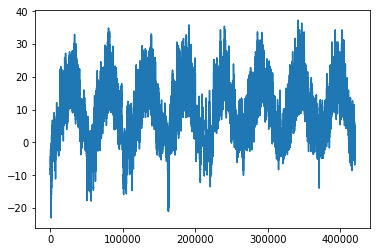

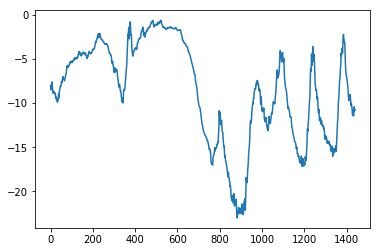

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.figure()
plt.plot(range(1440), temp[:1440])

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback

    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

        yield samples, targets

In [6]:
val_samples = 100000
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [7]:
# Baseline naive solution
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes) * std[1])

evaluate_naive_method()

2.564887434980494


In [8]:
def plot_loss(loss_values, val_loss_values):
    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 13s 26ms/step - loss: 1.2528 - val_loss: 0.5895
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3816 - val_loss: 0.3087
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2851 - val_loss: 0.3100
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2651 - val_loss: 0.3097
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2518 - val_loss: 0.3249
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2436 - val_loss: 0.3517
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2370 - val_loss: 0.3383
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2325 - val_loss: 0.3264
Epoch 9/20
500/500 [==============================] - 10s 20ms/s

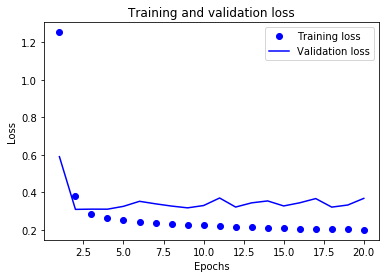

In [9]:
# Basic ML approach using fully connected layers
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

plot_loss(history.history['loss'], history.history['val_loss'])

Epoch 1/20
500/500 [==============================] - 165s 329ms/step - loss: 0.3031 - val_loss: 0.2729
Epoch 2/20
500/500 [==============================] - 164s 327ms/step - loss: 0.2831 - val_loss: 0.2737
Epoch 3/20
500/500 [==============================] - 162s 324ms/step - loss: 0.2766 - val_loss: 0.2700
Epoch 4/20
500/500 [==============================] - 162s 324ms/step - loss: 0.2714 - val_loss: 0.2675
Epoch 5/20
500/500 [==============================] - 162s 325ms/step - loss: 0.2672 - val_loss: 0.2631
Epoch 6/20
500/500 [==============================] - 162s 324ms/step - loss: 0.2616 - val_loss: 0.2666
Epoch 7/20
500/500 [==============================] - 162s 323ms/step - loss: 0.2568 - val_loss: 0.2680
Epoch 8/20
500/500 [==============================] - 161s 322ms/step - loss: 0.2511 - val_loss: 0.2739
Epoch 9/20
500/500 [==============================] - 161s 321ms/step - loss: 0.2479 - val_loss: 0.2768
Epoch 10/20
500/500 [==============================] - 161s 322m

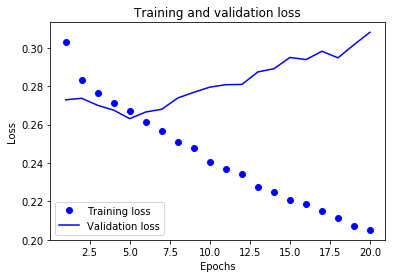

In [10]:
# Recurrent baseline (GRU)
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

plot_loss(history.history['loss'], history.history['val_loss'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Using TensorFlow backend.


Instructions for updating:
Use tf.cast instead.
Epoch 1/40
500/500 [==============================] - 198s 397ms/step - loss: 0.3387 - val_loss: 0.2795
Epoch 2/40
500/500 [==============================] - 195s 391ms/step - loss: 0.3146 - val_loss: 0.2771
Epoch 3/40
500/500 [==============================] - 196s 392ms/step - loss: 0.3094 - val_loss: 0.2722
Epoch 4/40
500/500 [==============================] - 194s 388ms/step - loss: 0.3045 - val_loss: 0.2705
Epoch 5/40
500/500 [==============================] - 193s 387ms/step - loss: 0.3010 - val_loss: 0.2679
Epoch 6/40
500/500 [==============================] - 195s 389ms/step - loss: 0.2995 - val_loss: 0.2705
Epoch 7/40
500/500 [==============================] - 193s 386ms/step - loss: 0.2995 - val_loss: 0.2668
Epoch 8/40
500/500 [==============================] - 194s 388ms/step - loss: 0.2960 - val_loss: 0.2650
Epoch 9/40
500/500 [==============================] - 194s 387ms/step - loss: 0.2956 - val_loss: 0.2652
Epoch 10/40
500/

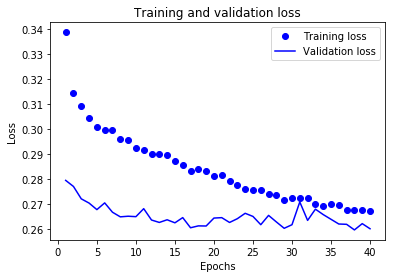

In [9]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Recurrent baseline (GRU) + Dropout regularization
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

plot_loss(history.history['loss'], history.history['val_loss'])

In [ ]:
# Stacking GRU layers
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64,
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

plot_loss(history.history['loss'], history.history['val_loss'])

In [ ]:
# Bidirectional RNN
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

plot_loss(history.history['loss'], history.history['val_loss'])

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
500/500 [==============================] - 12s 24ms/step - loss: 0.4221 - val_loss: 0.4435
Epoch 2/20
500/500 [==============================] - 11s 21ms/step - loss: 0.3608 - val_loss: 0.4383
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.3398 - val_loss: 0.4372
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3234 - val_loss: 0.4375
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3129 - val_loss: 0.4709
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3037 - val_loss: 0.4466
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2967 - val_loss: 0.4622
Epoch 8/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2897 - val_loss: 0.4766
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2832 - val_loss: 0.4519
Epoc

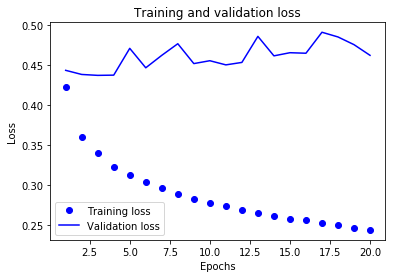

In [11]:
# Naive Conv1D
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

plot_loss(history.history['loss'], history.history['val_loss'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 73s 145ms/step - loss: 0.3418 - val_loss: 0.2797
Epoch 2/20
500/500 [===============

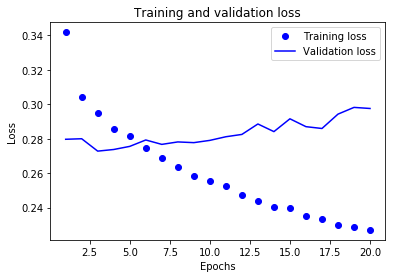

In [12]:
# Conv1D + RNN
lookback = 720
step = 3
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

plot_loss(history.history['loss'], history.history['val_loss'])